## Imports

In [1]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PIL for image operations
from PIL import Image

# For plotting and visualizations
import matplotlib.pyplot as plt

# For array operations
import numpy as np

# TensorBoardX: TensorBoard for PyTorch
from tensorboardX import SummaryWriter

import os

## Visualize Dimensions of Images
This this is so we can better understand our data and helps us to decide which fixed image size to choose

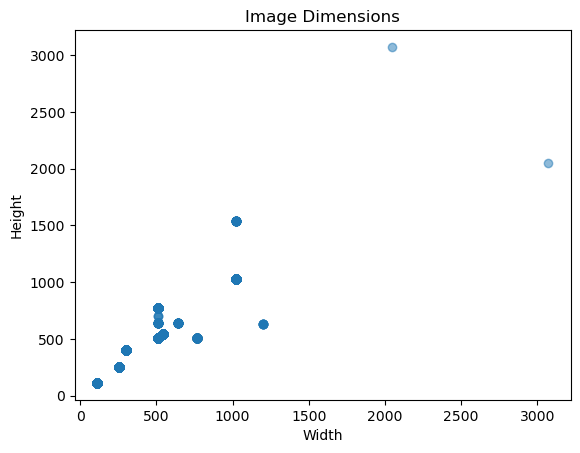

In [3]:
# Fake Images
image_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset/Fake/"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

for image_file in image_files:
    with Image.open(os.path.join(image_dir, image_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

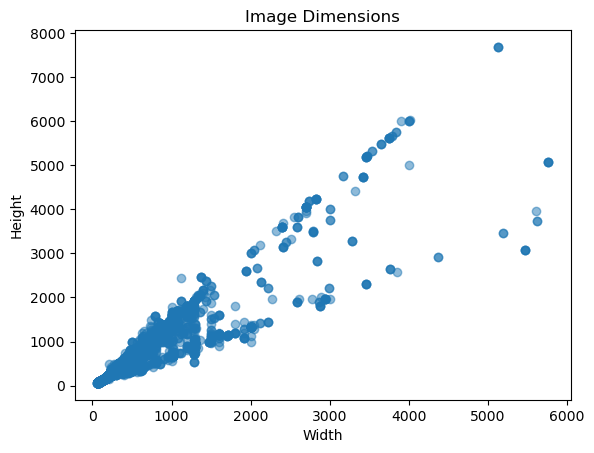

In [4]:
# Real Images
image_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset/Real/"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

for image_file in image_files:
    with Image.open(os.path.join(image_dir, image_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

plt.scatter(widths, heights, alpha=0.5)
plt.title('Real Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

## Setup Neural Networks

In [7]:
# This ConvNet could be used instead of the "ComplexCNN". It has less layers, and likely can detect less features, but is also less likely to overfit and faster
class CNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Dropout layer after convolutional layers (optional)
        self.dropout_conv = nn.Dropout(p=dropout_prob/2)  # Typically, dropout in convolutional layers is kept lower

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)  # After 2 max-pooling operations, the size becomes (28/2/2 = 7)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Conv layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Conv layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout after activation
        x = self.fc2(x)

        return x

In [8]:
class ComplexCNN(nn.Module):
    def __init__(self, dropout_prob=0.4):
        super(ComplexCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.5),

            # Conv layer 2
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.5),

            # Conv layer 3
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.5)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(128, 1)  # One output for binary classification
        )

    def feature_size(self):
        # Calculate size of flattened features
        return self.conv_layers(torch.zeros(1, 3, 32, 32)).view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [9]:
# Set the device to GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparamters

In [10]:
num_classes = 2
learning_rate = 0.0006
batch_size = 32
num_epochs = 9

## Data
- Load Data
- Split Data
- Apply transformations

In [11]:
class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        augmented = self.transform(image=image)
        image_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float() / 255.0
        return image_tensor

In [12]:
class TorchvisionBridge:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = self.transform(image)
        return np.array(image)

In [13]:
# Using data augmentation with the albumentations library
torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.Resize((256, 256))  # First, resize all images to 256x256
])

torchvision_resize = transforms.Compose(
    transforms.Resize((256, 256))
)

augmentation = A.Compose([
    A.RandomBrightnessContrast(p=0.1),
    A.RandomGamma(p=0.1),
    A.CLAHE(p=0.1),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.04, rotate_limit=8, p=0.3),
    A.GaussNoise(p=0.06),
    A.GaussianBlur(p=0.06),
    A.OpticalDistortion(p=0.02),
    A.GridDistortion(p=0.02),
    A.PixelDropout(dropout_prob=0.02, p=0.3),
    # A.ToTensorV2()  # Convert the image to PyTorch tensor. It should be the last transform.
])

test_augmentation = A.Compose([
    A.Resize(256, 256)
])

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        image = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            image = self.torchvision_transforms(image)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            image = self.albumentations_transform(image)
        
        return image, target

In [15]:
root_directory = '/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(43)

# Split dataset into train, validation, and test
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=augmentation
)

validation_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Explore and Visualize Data

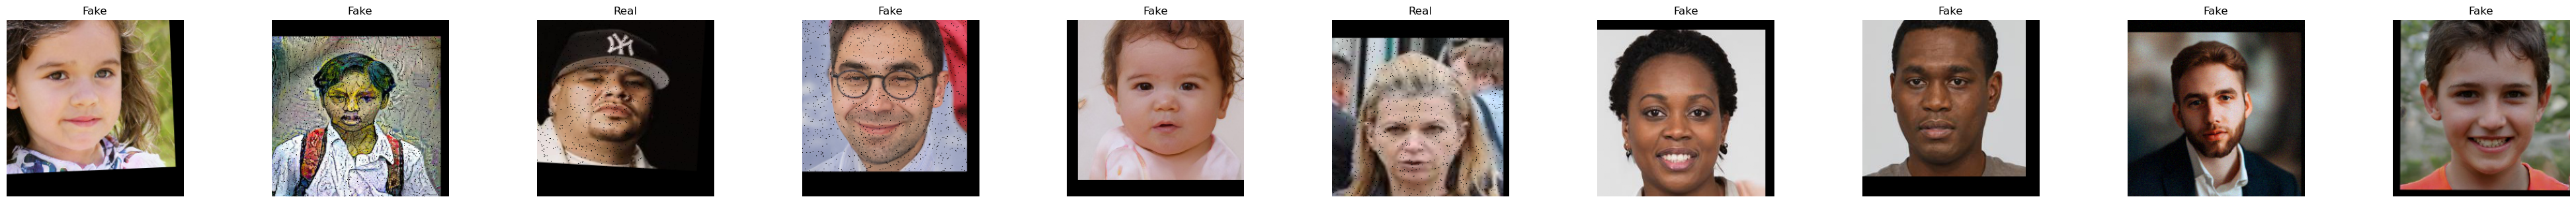

In [16]:
def imshow_with_labels(dataloader, class_names, num_images=10):
    """Display a batch of images with labels.
    Parameters:
    - dataloader (DataLoader): PyTorch DataLoader containing images and labels.
    - class_names (list): List of class names for labeling.
    - num_images (int, optional): Number of images to display. Default is 10.
    """
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(1, num_images, figsize=(50, 50), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for ax, img, lbl in zip(axes, images, labels):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a batch
imshow_with_labels(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [17]:
# Set a fixed random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and transfer it to the appropriate device (GPU or CPU)
model = ComplexCNN().to(device)

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

In [19]:
writer = SummaryWriter(f'runs/Aletheia2_1_1')
step = 0

## Define Function for Determining Accuracy of Model

In [20]:
def check_accuracy(loader, model):
    """
    Check the accuracy of the model on a given DataLoader.

    Parameters:
    - loader (DataLoader): DataLoader instance containing the dataset on which accuracy needs to be checked.
    - model (nn.Module): PyTorch model instance which needs to be evaluated.
    """

    print(type(loader))
    num_correct = 0
    num_samples = 0

    # Set the model to evaluation mode.
    model.eval()

    # Ensure no gradients are computed to save memory
    with torch.no_grad():
        for x, y in loader:

            # Move the data and labels to the appropriate device
            x = x.to(device=device)
            y = y.to(device=device)

            # Make predictions using the model
            scores = model(x)

            # Convert raw scores (logits) to binary predictions
            predictions = (torch.sigmoid(scores) > 0.5).squeeze().long()

            # Accumulate the number of correct predictions and total samples
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    # Set the model back to training mode
    model.train()

# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)

## Train Model

In [17]:
num_correct = 0
num_samples = 0

torch.manual_seed(42)

model = model.to(device)
log_interval = 200

for epoch in range(num_epochs):
    # Resetting accuracy counters at the beginning of each epoch
    num_correct = 0
    num_samples = 0
    
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = criterion(scores.view(-1), targets.float())
        # print(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent (or whatever optimizer you're using)
        optimizer.step()

        predictions = (torch.sigmoid(scores) > 0.5).float()
        num_correct += (predictions == targets).sum().item()
        num_samples += predictions.size(0)

        accuracy = 100 * num_correct / num_samples


        # Log the metrics to TensorBoard
        if batch_idx % log_interval == 0:
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_idx)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_idx)
            print("Epoch: ", epoch)
            print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

    print("Epoch: ", epoch)
    print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')
    scheduler.step()

    # Check accuracy on the test loader after each epoch
    print("Checking accuracy on Test Data")
    check_accuracy(validation_loader, model)  # Checking the accuracy on the test set
    test_accuracy = 100 * float(num_correct) / float(num_samples)
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)  # Add test accuracy to TensorBoard

    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2model6_epoch_{epoch}_num_correct{num_correct}.pth')

Epoch:  0
Got 27 / 32 with accuracy 84.38
Epoch:  0
Got 5670 / 6432 with accuracy 88.15
Epoch:  0
Got 11294 / 12832 with accuracy 88.01
Epoch:  0
Got 16967 / 19232 with accuracy 88.22
Epoch:  0
Got 22608 / 25632 with accuracy 88.20
Epoch:  0
Got 28243 / 32032 with accuracy 88.17
Epoch:  0
Got 33877 / 38432 with accuracy 88.15
Epoch:  0
Got 39555 / 44832 with accuracy 88.23
Epoch:  0
Got 45196 / 51232 with accuracy 88.22
Epoch:  0
Got 50891 / 57632 with accuracy 88.30
Epoch:  0
Got 56480 / 64032 with accuracy 88.21
Epoch:  0
Got 62129 / 70432 with accuracy 88.21
Epoch:  0
Got 67818 / 76832 with accuracy 88.27
Epoch:  0
Got 73497 / 83232 with accuracy 88.30
Epoch:  0
Got 79103 / 89632 with accuracy 88.25
Epoch:  0
Got 84752 / 96032 with accuracy 88.25
Epoch:  0
Got 90415 / 102432 with accuracy 88.27
Epoch:  0
Got 96020 / 108832 with accuracy 88.23
Epoch:  0
Got 101641 / 115232 with accuracy 88.21
Epoch:  0
Got 107319 / 121632 with accuracy 88.23
Epoch:  0
Got 112970 / 128032 with accurac

KeyboardInterrupt: 

## Test state_dict of Trained Model

In [58]:
model = ComplexCNN().to(device)

# Create a dummy input and perform a forward pass to dynamically create the fc1 layer
dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Assuming your input size is 256x256
model(dummy_input)

model_path = '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2model6_epoch_4_num_correct198659.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [59]:
check_accuracy(test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>
Got 23562 / 25752 with accuracy 91.50


### Test on Specific Generator

In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        image = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            image = self.torchvision_transforms(image)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            image = self.albumentations_transform(image)
        
        return image, target

In [54]:
# Load the new dataset
new_root_directory = "C:\\Users\\jacob\\OneDrive\\StableDiffusion"
new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Preprocess the new dataset
new_test_dataset = CustomDataset(
    new_full_dataset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on the new dataset
check_accuracy(new_test_loader, model)



<class 'torch.utils.data.dataloader.DataLoader'>
Got 2093 / 2159 with accuracy 96.94


### Try on individual Image

In [88]:
model.load_state_dict(torch.load('/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2model4_epoch_6_num_correct194465.pth'))

<All keys matched successfully>

In [89]:
model.to(device)

ComplexCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout_fc): Dropout(p=0.4, inplace=False)
)

In [29]:
def predict_single_image(image_path, model, torchvision_transform, albumentations_transform, device="cuda"):
    """
    Predicts the label for a single image using a pre-trained model.

    Parameters:
    - image_path (str): Path to the image which needs to be predicted.
    - model (nn.Module): Pre-trained PyTorch model instance.
    - torchvision_transform (transforms.Compose): Torchvision transformation to be applied.
    - albumentations_transform (AlbumentationsTransform): Albumentations transformation to be applied.
    - device (str): The device where the model and data should be loaded.

    Returns:
    - prediction (int): Predicted label for the image.
    """
    
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply torchvision transforms
    if torchvision_transform:
        image = torchvision_transform(image)
    
    # Apply albumentations transforms
    if albumentations_transform:
        image = albumentations_transform(image)

    # Add an extra batch dimension and move to the device
    image_tensor = image.unsqueeze(0).to(device)

    # Set the model to evaluation mode and predict
    model.eval()
    with torch.no_grad():
        scores = model(image_tensor)
        prediction = (torch.sigmoid(scores) > 0.5).squeeze().long().item()

    # Set the model back to training mode
    model.train()

    return prediction

In [49]:
image_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\Screenshot 2023-08-30 111618.png"
torchvision_resize = transforms.Compose([
    transforms.Resize((256, 256))
])
predicted_label = predict_single_image(
    image_path, 
    model, 
    torchvision_resize,  # Use the resize transform for prediction
    AlbumentationsTransform(test_augmentation)
)
print(f"Predicted label for the image: {predicted_label}")


Predicted label for the image: 0
